<a href="https://colab.research.google.com/github/AVJdataminer/UpworkFS/blob/master/Upwork_FS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install statsmodels

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels as sm
from scipy import stats
import os
os.listdir()

['.config',
 'CodeBook-SELECT.csv',
 'client-testset-1561457457-219.csv',
 'client-trainingset-1561457457-219.csv',
 'sample_data']

In [0]:
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive

In [0]:
#%cd ../content
#os.listdir()

In [0]:
#Load the code book for column description then add to df to sort by alphabetic for comparison groups.

file='CodeBook-SELECT.csv'
de=pd.read_csv(file)
print(de.shape)
de = de[['VarName','Description']]

nacnt = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df)).reset_index()
nacnt.columns = ['VarName', 'NACount']

de = de.merge(nacnt, on = 'VarName', how = 'left')

de.head()

(379, 10)


,VarName,Description,NACount
0,cntryid,"Country ID (ISO 3166, numeric)",0.00000
1,cntryid_e,Participating country or sub-national entity c...,0.00005
2,age_r,Person resolved age from BQ and QC check (esti...,0.39410
3,gender_r,Person resolved gender from BQ and QC check (e...,0.00000
4,v59,Formal Training and Education - Highest creden...,0.06590


## Start processing data here

In [0]:
file="client-trainingset-1561457457-219.csv"
df=pd.read_csv(file)
print(df.shape)

df = df.drop(['row'],axis=1)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (50,172,255,256,257,258,268,280,376) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(20000, 380)


## Select only numeric columns

In [0]:
dfn = df.select_dtypes(exclude=['object'])
dfn.shape

#Remove outliers based on IQR
#Q1 = dfn.quantile(0.25)
#Q3 = dfn.quantile(0.75)
#IQR = Q3 - Q1

#dfno = dfn[~((dfn < (Q1 - 1.5 * IQR)) |(dfn> (Q3 + 1.5 * IQR))).any(axis=1)]


#find those with 100% NA
pd.DataFrame(dfn.isnull().sum().sort_values(ascending=False)/len(df)).head()

,0
v262,1.00000
v110,0.99780
v100,0.99775
v160,0.99775
v215,0.99680


## Impute NA's in numeric columns and delete 100% NA columns

In [0]:
#impute NA's
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values='NaN', strategy='median', axis=0)

X=dfn
imputer = imputer.fit(X)
dfna = pd.DataFrame(imputer.transform(X), columns = dfn.drop(['v262'], axis=1).columns)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
dfna.head()

,age_r,yrsqual,yrsqual_t,yrsget,imyrs,leavedu,nfehrsnjr,nfehrsjr,nfehrs,isco1c,isco2c,isco1l,isco2l,earnhr,earnhrppp,earnhrbonus,earnhrbonusppp,earnmth,earnmthppp,earnmthselfppp,earnmthbonus,earnmthall,earnmthallppp,earnmthbonusppp,learnatwork,readytolearn,icthome,ictwork,influence,planning,readhome,readwork,taskdisc,writhome,writwork,job_performance,v202,v231,v272,v78,...,v268,v252,v206,v207,v133,v136,v187,v194,v154,v283,v145,v41,v45,v110,v160,v52,v97,v33,v242,v184,v104,v22,v241,v135,v235,v1,v100,v63,v87,v210,v169,v113,v130,v215,v163,v81,v156,v239,v224,v105
0,34.0,18.0,18.0,19.0,14.0,29.0,0.0,40.0,40.0,2.0,21.0,9996.0,9996.0,12.820513,16.234406,13.675214,17.316700,2500.000000,3165.709260,2389.341405,2666.666667,2666.666667,3376.756544,3376.756544,4.162505,2.602350,2.344334,3.020722,2.820357,2.407598,2.352009,2.056358,2.285993,2.438870,2.945252,3591.858256,29.0,29.0,2006.0,9.0,...,1.0,1.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0,4.0,5.0,20.0,2.0,43.0,2009.0,6.0,6.0,2.0,2.0,32.0,2009.0,32.0,2005.0,45.0,45.0,45.0,3.0,2080.0,30000.0,2000.0,54000.0,25.0,2009.0,29.0,2008.0,40.0,40.0,2144.0,9996.0,9996.0
1,38.0,13.0,13.0,15.0,14.0,22.0,0.0,16.0,16.0,7.0,72.0,9996.0,9996.0,28.901734,15.266724,32.221265,16.165944,5416.666667,2802.096894,2389.341405,5875.000000,5833.333333,2937.765754,2981.898073,1.024939,3.974608,2.428497,2.290220,2.833091,1.958027,2.731443,2.714136,2.311937,2.240891,2.945252,2777.423062,22.0,22.0,1996.0,9.0,...,1.0,1.0,2.0,2.0,3.0,2.0,4.0,1.0,1.0,4.0,2.0,20.0,2.0,43.0,2009.0,15.0,28.0,1.0,3.0,27.0,2005.0,32.0,2005.0,40.0,40.0,40.0,3.0,1.0,15000.0,7000.0,54000.0,25.0,2009.0,29.0,2008.0,40.0,40.0,9999.0,9996.0,9996.0
2,26.0,17.0,17.0,15.0,14.0,25.0,130.0,0.0,130.0,4.0,44.0,9996.0,9996.0,5.028902,7.023478,5.028902,7.023478,870.000000,1215.061636,2389.341405,870.000000,870.000000,1215.061636,1215.061636,4.162505,2.606679,3.436081,2.623446,2.601459,3.010131,3.262214,2.362329,1.466427,1.685187,2.556441,2937.211477,25.0,25.0,2010.0,13.0,...,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,4.0,5.0,130.0,2.0,43.0,2009.0,1.0,1.0,2.0,2.0,26.0,2011.0,32.0,2005.0,40.0,40.0,40.0,3.0,173.0,870.0,7000.0,54000.0,25.0,2009.0,29.0,2008.0,40.0,40.0,4416.0,9996.0,9996.0
3,38.0,15.0,15.0,17.0,14.0,22.0,0.0,40.0,40.0,3.0,31.0,9996.0,9996.0,28.901734,15.266724,32.221265,16.165944,5416.666667,2802.096894,2389.341405,5875.000000,5833.333333,2937.765754,2981.898073,2.165276,1.177736,2.952857,3.672402,2.274408,2.407598,1.799293,2.772508,2.313152,1.685187,2.351880,2826.298747,22.0,22.0,1996.0,9.0,...,1.0,1.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0,4.0,5.0,20.0,2.0,43.0,2009.0,15.0,25.0,1.0,1.0,27.0,2005.0,32.0,2005.0,43.0,43.0,43.0,3.0,173.0,15000.0,7000.0,54000.0,25.0,2009.0,29.0,2008.0,40.0,40.0,9999.0,9996.0,9996.0
4,40.0,15.0,15.0,14.0,14.0,22.0,0.0,40.0,70.0,3.0,34.0,9996.0,9996.0,18.497110,21.214037,21.574033,24.742910,3200.000000,3670.028398,2389.341405,3733.333333,3733.333333,4281.699798,4281.699798,2.840681,2.016924,2.283532,3.122650,2.461035,2.578113,2.063599,1.952151,3.730969,2.949319,3.490354,3007.439306,22.0,22.0,1994.0,9.0,...,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,4.0,5.0,70.0,2.0,43.0,2009.0,16.0,16.0,1.0,1.0,24.0,1996.0,32.0,2005.0,40.0,40.0,40.0,3.0,173.0,3200.0,6400.0,54000.0,25.0,2009.0,29.0,2008.0,40.0,40.0,3411.0,9996.0,9996.0


In [0]:
#boxplot = dfn.boxplot(grid=False, vert=False,fontsize=15, figsize=(12,20))

## Select object columns

In [0]:
dfo = df.select_dtypes(include=['object'])
print(dfo.shape)

#de.head()

#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn = vn.merge(de, on ='VarName', how = 'inner')
vn.head()

vn.sort_values(by='LevelsCount', ascending =False).head()

(20000, 295)


,VarName,LevelsCount,Description,NACount
293,v71,948,Current Job Industry - Respondent (ISIC rev 4)...,0.00175
11,reg_tl2,175,Geographical region - Respondent (OECD TL2) (c...,0.20305
41,isic2l,115,Industry classification of respondent's job at...,0.06080
43,isic2c,101,Industry classification of respondent's job at...,0.00430
10,cnt_brth,91,Country of birth - Respondent (UN M49 numerica...,0.43930


In [0]:
vn.to_csv('Levels_train.csv')

## Create dummy vars and concat with numeric

In [0]:
df = pd.concat([dfna, pd.get_dummies(dfo)], axis=1).drop(['timestamp_1561457457-219'], axis =1)
print(df.shape)
df.head()

(20000, 3042)


,age_r,yrsqual,yrsqual_t,yrsget,imyrs,leavedu,nfehrsnjr,nfehrsjr,nfehrs,isco1c,isco2c,isco1l,isco2l,earnhr,earnhrppp,earnhrbonus,earnhrbonusppp,earnmth,earnmthppp,earnmthselfppp,earnmthbonus,earnmthall,earnmthallppp,earnmthbonusppp,learnatwork,readytolearn,icthome,ictwork,influence,planning,readhome,readwork,taskdisc,writhome,writwork,job_performance,v202,v231,v272,v78,...,v71_871,v71_8710,v71_8730,v71_8790,v71_8810,v71_889,v71_8890,v71_90,v71_900,v71_9000,v71_9101,v71_9102,v71_9103,v71_92,v71_9200,v71_93,v71_9311,v71_9312,v71_9319,v71_9329,v71_941,v71_9411,v71_9412,v71_9420,v71_9491,v71_9499,v71_9511,v71_9522,v71_9529,v71_9601,v71_9602,v71_9603,v71_9609,v71_9700,v71_9996,v71_9997,v71_9998,v71_9999,v71_C,v71_G
0,34.0,18.0,18.0,19.0,14.0,29.0,0.0,40.0,40.0,2.0,21.0,9996.0,9996.0,12.820513,16.234406,13.675214,17.316700,2500.000000,3165.709260,2389.341405,2666.666667,2666.666667,3376.756544,3376.756544,4.162505,2.602350,2.344334,3.020722,2.820357,2.407598,2.352009,2.056358,2.285993,2.438870,2.945252,3591.858256,29.0,29.0,2006.0,9.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38.0,13.0,13.0,15.0,14.0,22.0,0.0,16.0,16.0,7.0,72.0,9996.0,9996.0,28.901734,15.266724,32.221265,16.165944,5416.666667,2802.096894,2389.341405,5875.000000,5833.333333,2937.765754,2981.898073,1.024939,3.974608,2.428497,2.290220,2.833091,1.958027,2.731443,2.714136,2.311937,2.240891,2.945252,2777.423062,22.0,22.0,1996.0,9.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,26.0,17.0,17.0,15.0,14.0,25.0,130.0,0.0,130.0,4.0,44.0,9996.0,9996.0,5.028902,7.023478,5.028902,7.023478,870.000000,1215.061636,2389.341405,870.000000,870.000000,1215.061636,1215.061636,4.162505,2.606679,3.436081,2.623446,2.601459,3.010131,3.262214,2.362329,1.466427,1.685187,2.556441,2937.211477,25.0,25.0,2010.0,13.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,38.0,15.0,15.0,17.0,14.0,22.0,0.0,40.0,40.0,3.0,31.0,9996.0,9996.0,28.901734,15.266724,32.221265,16.165944,5416.666667,2802.096894,2389.341405,5875.000000,5833.333333,2937.765754,2981.898073,2.165276,1.177736,2.952857,3.672402,2.274408,2.407598,1.799293,2.772508,2.313152,1.685187,2.351880,2826.298747,22.0,22.0,1996.0,9.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,40.0,15.0,15.0,14.0,14.0,22.0,0.0,40.0,70.0,3.0,34.0,9996.0,9996.0,18.497110,21.214037,21.574033,24.742910,3200.000000,3670.028398,2389.341405,3733.333333,3733.333333,4281.699798,4281.699798,2.840681,2.016924,2.283532,3.122650,2.461035,2.578113,2.063599,1.952151,3.730969,2.949319,3.490354,3007.439306,22.0,22.0,1994.0,9.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## EDA Plots

In [0]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [0]:
#core = df.dropna().corr().job_performance
#make correlation plots
#x=pd.DataFrame(core.sort_values(ascending = False))
#names = list(x.index)
#values = list(x.job_performance)
#del values[0]
#del names[0]
#f, ax = plt.subplots(figsize=(10, 10))
#sns.set(style="whitegrid")
#sns.barplot(x=values, y=names, palette="RdBu_r")

In [0]:
coln = 'yrsqual'
pd.DataFrame(pd.pivot_table(df, values='job_performance', columns=[coln], aggfunc=np.sum).T).sort_values(by='job_performance').plot(kind = 'barh',rot=0, figsize=(10,10))
#fig1 =plt.gfc()
plt.show()

In [0]:
hist = df.hist(bins=10,figsize =(25,25))

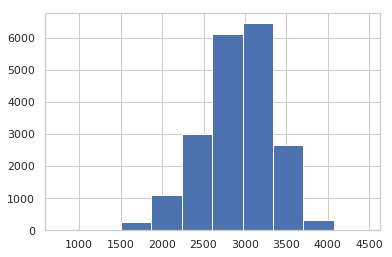

In [0]:
df.job_performance.hist()

## Scale data in prep for modeling

In [0]:
#scale data
from sklearn import preprocessing
import numpy as np
X=df.drop(['job_performance'], axis=1)
y=df[['job_performance']].values  #convert to numpy arrays
scaler = preprocessing.StandardScaler().fit(X)
X_scaled=scaler.transform(X) 

## Create PCA

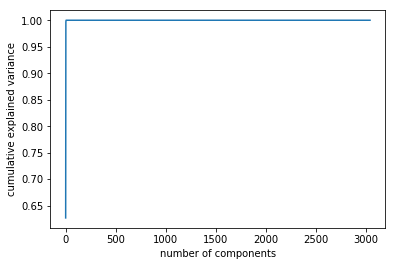

In [0]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


In [0]:
pca = PCA(.95)

In [0]:
pca.fit(X_train)
train_pca = pca.transform(X_train)
test_pca = pca.transform(X_test)
np.shape(train_pca)

(15000, 1720)

## Split into test and train subsamples

In [0]:
y=y.ravel()
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=1)



## Gradient Boosted Model


In [0]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE: 82537.6682


Text(0, 0.5, 'Deviance')

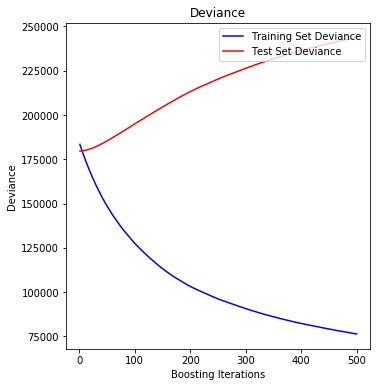

In [0]:
# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [0]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size

30


30

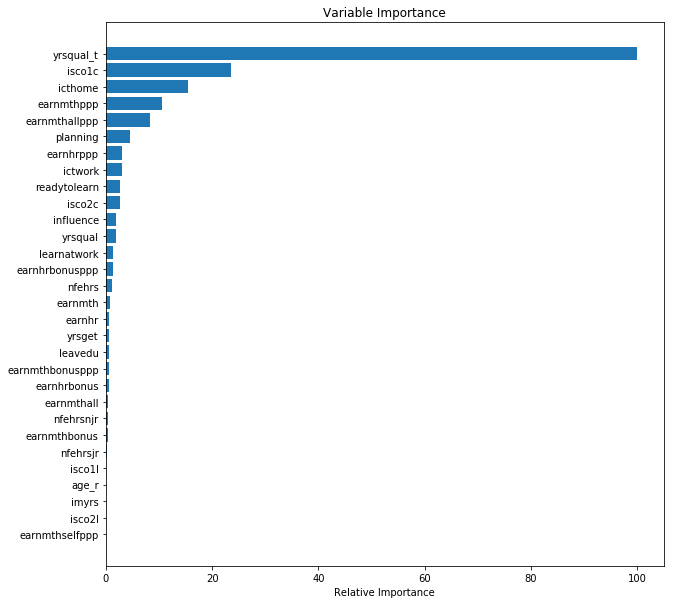

In [0]:
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [0]:
type(y_test)

pandas.core.frame.DataFrame

## Lasso Regression

In [0]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from math import sqrt
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

val_errors = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=77)
    errors = np.sum(-cross_val_score(lasso,X_train, y=y_train,
    scoring='neg_mean_squared_error', cv=10, n_jobs=-1))
    val_errors.append(np.sqrt(errors))
    
print('best alpha: {}'.format(alphas[np.argmin(val_errors)]))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 392632662.5538408, tolerance: 292641.1780141725
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393705763.6026454, tolerance: 292255.44491409755
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 396856690.96036285, tolerance: 294071.2878678669
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 398058754.9718

KeyboardInterrupt: ignored

In [0]:
#Fit the model
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from math import sqrt
lassoreg = Lasso(alpha=0.01,normalize=True, max_iter=1e5)
lassoreg.fit(X_train,y_train)
y_pred = lassoreg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

75988.07737359773

In [0]:
#Fit the model with pca
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from math import sqrt
lassoreg = Lasso(alpha=0.01,normalize=True, max_iter=1e5)
lassoreg.fit(train_pca,y_train)
y_pred = lassoreg.predict(test_pca)
mse = mean_squared_error(y_test, y_pred)
mse

82078.33030188167

## Random Forest Regressor

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {"n_estimators": [200, 500],
  "max_depth": [3, None],
   "max_features": [1, 3, 5, 10],
   "min_samples_split": [2, 5, 10],
   "min_samples_leaf": [1, 3, 10],
   "bootstrap": [True, False]}

model = RandomForestRegressor(random_state=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_score_)
print(grid.best_params_)

In [0]:
regressor = RandomForestRegressor(random_state=0, n_estimators=300, max_depth=None, max_features=10, 
                                  min_samples_leaf=1, min_samples_split=2, bootstrap=False)
regressor.fit(X_train, y_train)
regressor.score(X_test, y_test)
y_pred = regressor.predict(X_test)
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(y_test, y_pred)
mse

30591.062890189194

In [0]:
file="client-testset-1561457457-219.csv"
dft=pd.read_csv(file)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (50,255,256,257,258,260,268,280) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
dft = pd.read_csv('client-testset-1561457457-219.csv')
dft = dft.drop(['row','job_performance'],axis=1)
dftn = dft.select_dtypes(exclude=['object'])
imputer = Imputer(missing_values='NaN', strategy='median', axis=0)
imputer = imputer.fit(dftn)
dftna = pd.DataFrame(imputer.transform(dftn), columns = dftn.drop(['v262'], axis=1).columns)
dfo = dft.select_dtypes(include=['object'])
"""## Create dummy vars and concat with numeric"""
dft = pd.concat([dftna, pd.get_dummies(dfo)], axis=1).drop(['timestamp_1561457457-219'], axis =1)
dft.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (50,255,256,257,258,260,268,280) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


(20000, 2248)

In [0]:
dft = pd.read_csv('client-testset-1561457457-219.csv').drop(['row','job_performance'],axis=1)
imputer = Imputer(missing_values='NaN', strategy='median', axis=0)
imputer = imputer.fit(dft.select_dtypes(exclude=['object']))
dfna = pd.DataFrame(imputer.transform(dft.select_dtypes(exclude=['object'])), columns = dft.drop(['v262'], axis=1).columns)

#dft.select_dtypes(include=['object']).head()
#vnt = pd.DataFrame(dft.select_dtypes(include=['object']).nunique()).reset_index()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (50,255,256,257,258,260,268,280) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


ValueError: ignored

In [0]:
dft = dft.drop(['row','job_performance'],axis=1)
dft.columns.difference(df.columns)

Index([], dtype='object')

In [0]:
vnt.head()

,index,0
0,cntryid,31
1,cntryid_e,33
2,gender_r,2
3,computerexperience,2
4,nativespeaker,2


In [0]:
vnt.columns = ['VarName', 'LevelsCount']
vnt = vnt.merge(de, on ='VarName', how = 'inner')
vnt.head()

vnt.sort_values(by='LevelsCount', ascending =False).head()

,VarName,LevelsCount,Description,NACount
11,reg_tl2,178,Geographical region - Respondent (OECD TL2) (c...,0.20305
41,isic2l,167,Industry classification of respondent's job at...,0.06080
10,cnt_brth,127,Country of birth - Respondent (UN M49 numerica...,0.43930
43,isic2c,103,Industry classification of respondent's job at...,0.00430
8,lng_home,75,Language most often spoken in domestic setting...,0.00065


In [0]:
vnt.shape

(293, 4)

In [0]:
scaler = preprocessing.StandardScaler().fit(dft)
X_scaled=scaler.transform(dft)
y_pred = regressor.predict(dft)
#df['job_performance'] = y_pred
print(y_pred)

In [0]:
dft = df.drop(['job_performance'],axis=1)

In [0]:
dft.shape

(20000, 3041)

In [0]:
dft.columns


Index(['age_r', 'yrsqual', 'yrsqual_t', 'yrsget', 'imyrs', 'leavedu',
       'nfehrsnjr', 'nfehrsjr', 'nfehrs', 'isco1c',
       ...
       'v71_9602', 'v71_9603', 'v71_9609', 'v71_9700', 'v71_9996', 'v71_9997',
       'v71_9998', 'v71_9999', 'v71_C', 'v71_G'],
      dtype='object', length=3041)

In [0]:
#30591.062890189194

32645.03914444902

In [0]:
regressor.fit(train_pca, y_train)
y_pred = regressor.predict(test_pca)
mse = mean_squared_error(y_test, y_pred)
mse

49435.28914274105

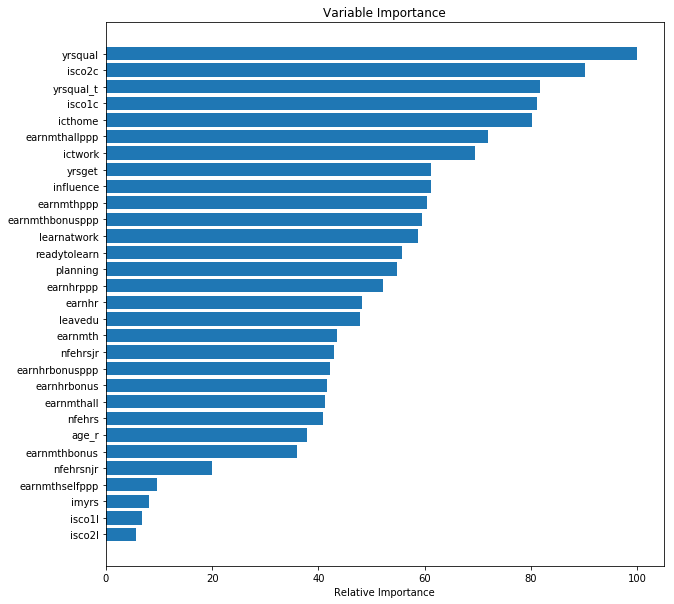

In [0]:
# Plot feature importance
feature_importance = regressor.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()